# Bitcoin Twitter Sentiment Analysis
### Unsupervised Learning and Natural Language Processing (NLP)
Focusing on Bitcoin sentiment via Tweets and observing if there is a correlation between a positive/negative sentiment and the price. 

### Data
Tweets scraped via SNScrape and Tweepy 

### Skills and Tools

 - **NLP**
   - **Text preprocessing, Count/TF-IDF Vectorizer**
 - **Unsupervised learning**
   - **Dimensionality reduction**: SVD/PCA
      - **Topic modeling**: LSA (TruncatedSVD), NMF, LDA, CorEx
   - **App** - App built using Streamlit

### Sources
- Scraping Twitter: https://github.com/JustAnotherArchivist/snscrape/tree/master/snscrape
- SNScrape + Tweepy: https://medium.com/@jcldinco/downloading-historical-tweets-using-tweet-ids-via-snscrape-and-tweepy-5f4ecbf19032
- Tweet Preprocessing: https://www.kaggle.com/sreejiths0/efficient-tweet-preprocessing
- Sentiment Analysis: https://medium.com/better-programming/twitter-sentiment-analysis-15d8892c0082

In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os

# from newsapi_help_func import *
%load_ext autoreload
%autoreload 2

#Corex Setup
# Install CorEx 
# !pip install corextopic
# !pip install networkx

# Import other packages for examples
import scipy.sparse as ss

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

import pandas as pd
import numpy as np
import json

from collections import Counter
from gensim.parsing.preprocessing import remove_stopwords
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import re, string, unicodedata
import nltk
from nltk import ngrams, word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords, words
from nltk.stem import LancasterStemmer, WordNetLemmatizer
# nltk.download
# nltk.download('wordnet')
# nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
# !pip install ekphrasis
# !pip install tweet-preprocessor
import preprocessor as p
from pyemd import emd

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import tweepy 

import seaborn as sns

import scattertext as st

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from string import punctuation

import spacy
from spacy import displacy
from spacy.symbols import amod
# Optional - download a language model for SpaCy
# !python -m spacy download en_core_web_sm
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

#For Sentiment Analysis
from textblob import TextBlob
from wordcloud import WordCloud
plt.style.use('fivethirtyeight')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.0 Scraping
First we will scrape all the Tweets we need using SNScrape and Tweepy. We will focus on Nov 1, 2020, Tweets right after the Bitcoin price started to rise to $16,000.

In [10]:
!snscrape twitter-search  "#Bitcoin since:2020-11-01 until: 2020-11-02" > btc_tweets_daily.txt

usage: snscrape [-h] [--version] [-v] [--dump-locals] [--retry N] [-n N]
                [-f FORMAT] [--since DATETIME]
                {telegram-channel,vkontakte-user,googleplus-user,facebook-user,facebook-group,gab-user,gab-user-comments,gab-user-media,twitter-search,twitter-thread,twitter-list-members,instagram-user,instagram-hashtag,instagram-location,twitter-user,twitter-hashtag,twitter-list-posts}
                ...
snscrape: error: argument scraper: invalid choice: 'twitter-hahtag' (choose from 'telegram-channel', 'vkontakte-user', 'googleplus-user', 'facebook-user', 'facebook-group', 'gab-user', 'gab-user-comments', 'gab-user-media', 'twitter-search', 'twitter-thread', 'twitter-list-members', 'instagram-user', 'instagram-hashtag', 'instagram-location', 'twitter-user', 'twitter-hashtag', 'twitter-list-posts')


API Keys from Twitter Developer Account: Exported to environment 

Source: https://developer.twitter.com/en/docs/authentication/guides/authentication-best-practices

In [5]:
consumer_key = os.environ.get('CONSUMER_KEY')
consumer_secret = os.environ.get('CONSUMER_SECRET')
access_token = os.environ.get('ACCESS_TOKEN') 
access_token_secret = os.environ.get('ACCESS_SECRET')
auth = tweepy.OAuthHandler(consumer_key, consumer_secret) 
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

Now that we've pulled all the links to the Tweets that we need we'll pull it a CSV file and start extracting the information we need.

In [6]:
tweet_url = pd.read_csv("./data/bitcoin_tweets.txt", index_col= None, header = None, names = ["links"])
tweet_url.head()

links
0  https://twitter.com/JoaoDMendes/status/1322689...
1  https://twitter.com/Z06Z07/status/132268980142...
2  https://twitter.com/PoisonI96460421/status/132...
3  https://twitter.com/CryptoWatchBot/status/1322...
4  https://twitter.com/planethardmoney/status/132...

 Extract tweet_id using .split function

In [7]:
tweet_url.iloc[0]['links']

'https://twitter.com/JoaoDMendes/status/1322689810381840385'

In [8]:
af = lambda x: x["links"].split("/")[-1]
tweet_url['id'] = tweet_url.apply(af, axis=1)
tweet_url.head()

links                   id
0  https://twitter.com/JoaoDMendes/status/1322689...  1322689810381840385
1  https://twitter.com/Z06Z07/status/132268980142...  1322689801422696450
2  https://twitter.com/PoisonI96460421/status/132...  1322689799975653376
3  https://twitter.com/CryptoWatchBot/status/1322...  1322689779755032577
4  https://twitter.com/planethardmoney/status/132...  1322689752978624513

Convert tweet_url Series into list

In [9]:
ids = tweet_url['id'].tolist()

Issue looping through all ids, the API is giving an error. Therefore, process the ids by batch or chunks

In [10]:
total_count = len(ids)
chunks = (total_count - 1) // 50 + 1

Create function that would extract all elements that we need from the tweet (username, date and the tweet).

In [8]:
def fetch_tw(ids):
    list_of_tw_status = api.statuses_lookup(ids, tweet_mode= "extended")
    empty_data = pd.DataFrame()
    for status in list_of_tw_status:
            tweet_elem = {"tweet_id": status.id,
                     "screen_name": status.user.screen_name,
                     "tweet":status.full_text,
                     "date":status.created_at}
            empty_data = empty_data.append(tweet_elem, ignore_index = True)
    empty_data.to_csv("./data/bitcoin_tweets.csv", mode="a")

Create another for loop to loop into our batches while processing 50 entries every loop. (That felt like a tongue twister)

In [54]:
for i in range(chunks):
        batch = ids[i*50:(i+1)*50]
        result = fetch_tw(batch)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
df_tweets = pd.read_csv('./data/btc_tweets.csv',
                 lineterminator='\n')

In [7]:
df_tweets['date'] = pd.to_datetime(df_tweets['date'], errors='coerce')

In [8]:
df_tweets = df_tweets.sort_values('date')
df_tweets

Unnamed: 0                date      screen_name  \
15235        15.0 2020-10-31 10:51:25  bmurphypointman   
15223         3.0 2020-10-31 10:51:25        yanggao01   
15239        19.0 2020-10-31 10:51:31       NimzoValue   
15220         0.0 2020-10-31 10:51:32     ModernInvest   
15240        20.0 2020-10-31 10:51:44       fawazshola   
...           ...                 ...              ...   
15015         NaN                 NaT      screen_name   
15066         NaN                 NaT      screen_name   
15117         NaN                 NaT      screen_name   
15168         NaN                 NaT      screen_name   
15219         NaN                 NaT      screen_name   

                                                   tweet  \
15235  #investor #DigitalMarketing #SEO #Bitcoin #net...   
15223  probably. threwback to between .618-.786 of mi...   
15239  You use VPN, p2p exchanges, no KYC, coinjoin w...   
15220  Here we goooooooo\n\n#Bitcoin #Btc #Investing ...   
15240  Welcome to a New World. \n\n#BITCOIN\n#CRYPTO\...   
...                                                  ...   
15015                                              tweet   
15066                                              tweet   
15117                                              tweet   
15168                                              tweet   
15219                                              tweet   

                     tweet_id  
15235   1.322491359555707e+18  
15223  1.3224913603441582e+18  
15239  1.3224913862859284e+18  
15220  1.3224913896498463e+18  
15240  1.3224914394991247e+18  
...                       ...  
15015                tweet_id  
15066                tweet_id  
15117                tweet_id  
15168                tweet_id  
15219                tweet_id  

[15270 rows x 5 columns]

In [9]:
df_tweets.count()

Unnamed: 0     14971
date           14971
screen_name    15270
tweet          15270
tweet_id       15270
dtype: int64

## 2.0 Tweet Preprocessing 
Since we are dealing with tweets in this competition, we need to do specific tweet text cleaning along with normal text pre-processing. A tweet may contain:
- URL's
- Mentions
- Hashtags
- Emojis
- Smileys
- Spefic words etc.

To clean the tweet, a function was written to preprocess.

Apply tweet preprocessing first. Defining a preprocess function and using pandas apply to apply it on each value of 'text'. 

Preprocessing:
- Lowercasing
- Punctuation Removal
- Replace extra white spaces
- Stopwords removal
- For stop word removal , i have used gensim library

Source: https://www.kaggle.com/sreejiths0/efficient-tweet-preprocessing

In [10]:
df_tweets['hashtag'] = df_tweets.tweet.apply(lambda x: re.findall(r"#(\w+)", x))
df_tweets['emojis'] = df_tweets.tweet.apply(lambda x: re.findall(r'[^\x00-\x7F]+', x))
df_tweets = df_tweets.dropna()
df_tweets = df_tweets.drop(['Unnamed: 0', 'tweet_id'], axis=1)

In [11]:
df_tweets

date      screen_name  \
15235 2020-10-31 10:51:25  bmurphypointman   
15223 2020-10-31 10:51:25        yanggao01   
15239 2020-10-31 10:51:31       NimzoValue   
15220 2020-10-31 10:51:32     ModernInvest   
15240 2020-10-31 10:51:44       fawazshola   
...                   ...              ...   
14    2020-10-31 23:59:46  planethardmoney   
28    2020-10-31 23:59:52   CryptoWatchBot   
15    2020-10-31 23:59:57           Z06Z07   
47    2020-10-31 23:59:57  PoisonI96460421   
12    2020-10-31 23:59:59      JoaoDMendes   

                                                   tweet  \
15235  #investor #DigitalMarketing #SEO #Bitcoin #net...   
15223  probably. threwback to between .618-.786 of mi...   
15239  You use VPN, p2p exchanges, no KYC, coinjoin w...   
15220  Here we goooooooo\n\n#Bitcoin #Btc #Investing ...   
15240  Welcome to a New World. \n\n#BITCOIN\n#CRYPTO\...   
...                                                  ...   
14       Happy Birthday #bitcoin https://t.co/GmKIOwqiz1   
28     #Investing 134.0% in this optimal #crypto port...   
15     @Travis_Kling @Pladizow This chart by @jjcmore...   
47     @seaswap Let's go!\n@yANA_eIAH\n@ElenaCayosa\n...   
12     21 Million #BTC—a number that is only divisibl...   

                                                 hashtag emojis  
15235  [investor, DigitalMarketing, SEO, Bitcoin, net...     []  
15223  [bitcoin, ElectionDay, Decision2020, everythin...     []  
15239                                     [wtf, Bitcoin]    [’]  
15220  [Bitcoin, Btc, Investing, crypto, cryptocurren...     []  
15240             [BITCOIN, CRYPTO, BLOCKCHAIN, NEWTECH]     []  
...                                                  ...    ...  
14                                             [bitcoin]     []  
28              [Investing, crypto, cash, Bitcoin, risk]     []  
15                                             [Bitcoin]     []  
47     [Halloween2020, HappyHalloween2020, HalloweenA...     []  
12     [BTC, Bitcoin, Crypto, cryptocurrency, cryptoc...    [—]  

[14971 rows x 5 columns]

In [12]:
def preprocess_tweet(row):
    text = row['tweet']
    text = p.clean(text) #clean to normal text removes hashtags and emojis
    text = re.sub(r'[^\w]', ' ', text) #Removes all symbols
    text = text.lower() # lowercases all words
    text = re.sub(r'\d+', '', text) # Removes numbers
    text = re.sub('RT[\s]+', '', text) # Removing RT (Retweet?)
    text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink
    text = remove_stopwords(text) #removes stopwords
    text = re.sub(r'\W*\b\w{1,2}\b', '', text) #Removes words between 1 and 2 characters short
    
    return text

df_tweets['tweet'] = df_tweets.apply(preprocess_tweet, axis=1)

df_tweets['tokens'] = df_tweets['tweet'].apply(word_tokenize) 

df_tweets.head()

date      screen_name  \
15235 2020-10-31 10:51:25  bmurphypointman   
15223 2020-10-31 10:51:25        yanggao01   
15239 2020-10-31 10:51:31       NimzoValue   
15220 2020-10-31 10:51:32     ModernInvest   
15240 2020-10-31 10:51:44       fawazshola   

                                                   tweet  \
15235  check website recommended business tools programs   
15223  probably threwback micro wave bullish retrace ...   
15239  use vpn exchanges kyc coinjoin loses data cong...   
15220                                          goooooooo   
15240                                  welcome new world   

                                                 hashtag emojis  \
15235  [investor, DigitalMarketing, SEO, Bitcoin, net...     []   
15223  [bitcoin, ElectionDay, Decision2020, everythin...     []   
15239                                     [wtf, Bitcoin]    [’]   
15220  [Bitcoin, Btc, Investing, crypto, cryptocurren...     []   
15240             [BITCOIN, CRYPTO, BLOCKCHAIN, NEWTECH]     []   

                                                  tokens  
15235  [check, website, recommended, business, tools,...  
15223  [probably, threwback, micro, wave, bullish, re...  
15239  [use, vpn, exchanges, kyc, coinjoin, loses, da...  
15220                                        [goooooooo]  
15240                              [welcome, new, world]

Everything seems cleaned up so now we can move onto Sentiment Analysis.

## 3.0 Sentiment Analysis

The functions called will add the tweets’ subjectivity and polarity into two columns in the DataFrame. 
- getSubjectivity function: How subjective/opinionated the text is 
    - Score of 0 is fact
    - Score of +1 is very much an opinion 
- getPolarity: How positive or negative the text is
    - Score of -1 is the highest negative score
    - Score of +1 is the highest positive score

Source: https://medium.com/better-programming/twitter-sentiment-analysis-15d8892c0082

In [13]:
# Create a function to get the subjectivity
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
df_tweets['Subjectivity'] = df_tweets['tweet'].apply(getSubjectivity)
df_tweets['Polarity'] = df_tweets['tweet'].apply(getPolarity)

# Show the new dataframe with columns 'Subjectivity' & 'Polarity'
df_tweets

date      screen_name  \
15235 2020-10-31 10:51:25  bmurphypointman   
15223 2020-10-31 10:51:25        yanggao01   
15239 2020-10-31 10:51:31       NimzoValue   
15220 2020-10-31 10:51:32     ModernInvest   
15240 2020-10-31 10:51:44       fawazshola   
...                   ...              ...   
14    2020-10-31 23:59:46  planethardmoney   
28    2020-10-31 23:59:52   CryptoWatchBot   
15    2020-10-31 23:59:57           Z06Z07   
47    2020-10-31 23:59:57  PoisonI96460421   
12    2020-10-31 23:59:59      JoaoDMendes   

                                                   tweet  \
15235  check website recommended business tools programs   
15223  probably threwback micro wave bullish retrace ...   
15239  use vpn exchanges kyc coinjoin loses data cong...   
15220                                          goooooooo   
15240                                  welcome new world   
...                                                  ...   
14                                        happy birthday   
28       optimal portfolio past hours given return level   
15     chart shows interesting phenomenon needs conse...   
47                                                   let   
12     million number divisible numbers cosmic power ...   

                                                 hashtag emojis  \
15235  [investor, DigitalMarketing, SEO, Bitcoin, net...     []   
15223  [bitcoin, ElectionDay, Decision2020, everythin...     []   
15239                                     [wtf, Bitcoin]    [’]   
15220  [Bitcoin, Btc, Investing, crypto, cryptocurren...     []   
15240             [BITCOIN, CRYPTO, BLOCKCHAIN, NEWTECH]     []   
...                                                  ...    ...   
14                                             [bitcoin]     []   
28              [Investing, crypto, cash, Bitcoin, risk]     []   
15                                             [Bitcoin]     []   
47     [Halloween2020, HappyHalloween2020, HalloweenA...     []   
12     [BTC, Bitcoin, Crypto, cryptocurrency, cryptoc...    [—]   

                                                  tokens  Subjectivity  \
15235  [check, website, recommended, business, tools,...      0.000000   
15223  [probably, threwback, micro, wave, bullish, re...      0.000000   
15239  [use, vpn, exchanges, kyc, coinjoin, loses, da...      0.550000   
15220                                        [goooooooo]      0.000000   
15240                              [welcome, new, world]      0.677273   
...                                                  ...           ...   
14                                     [happy, birthday]      1.000000   
28     [optimal, portfolio, past, hours, given, retur...      0.250000   
15     [chart, shows, interesting, phenomenon, needs,...      0.500000   
47                                                 [let]      0.000000   
12     [million, number, divisible, numbers, cosmic, ...      0.454545   

       Polarity  
15235  0.000000  
15223  0.000000  
15239 -0.400000  
15220  0.000000  
15240  0.468182  
...         ...  
14     0.800000  
28    -0.250000  
15     0.500000  
47     0.000000  
12     0.136364  

[14971 rows x 8 columns]

In [14]:
# Create a function to compute negative (-1), neutral (0) and positive (+1) analysis
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

df_tweets['Analysis'] = df_tweets['Polarity'].apply(getAnalysis)
# Show the dataframe
df_tweets

date      screen_name  \
15235 2020-10-31 10:51:25  bmurphypointman   
15223 2020-10-31 10:51:25        yanggao01   
15239 2020-10-31 10:51:31       NimzoValue   
15220 2020-10-31 10:51:32     ModernInvest   
15240 2020-10-31 10:51:44       fawazshola   
...                   ...              ...   
14    2020-10-31 23:59:46  planethardmoney   
28    2020-10-31 23:59:52   CryptoWatchBot   
15    2020-10-31 23:59:57           Z06Z07   
47    2020-10-31 23:59:57  PoisonI96460421   
12    2020-10-31 23:59:59      JoaoDMendes   

                                                   tweet  \
15235  check website recommended business tools programs   
15223  probably threwback micro wave bullish retrace ...   
15239  use vpn exchanges kyc coinjoin loses data cong...   
15220                                          goooooooo   
15240                                  welcome new world   
...                                                  ...   
14                                        happy birthday   
28       optimal portfolio past hours given return level   
15     chart shows interesting phenomenon needs conse...   
47                                                   let   
12     million number divisible numbers cosmic power ...   

                                                 hashtag emojis  \
15235  [investor, DigitalMarketing, SEO, Bitcoin, net...     []   
15223  [bitcoin, ElectionDay, Decision2020, everythin...     []   
15239                                     [wtf, Bitcoin]    [’]   
15220  [Bitcoin, Btc, Investing, crypto, cryptocurren...     []   
15240             [BITCOIN, CRYPTO, BLOCKCHAIN, NEWTECH]     []   
...                                                  ...    ...   
14                                             [bitcoin]     []   
28              [Investing, crypto, cash, Bitcoin, risk]     []   
15                                             [Bitcoin]     []   
47     [Halloween2020, HappyHalloween2020, HalloweenA...     []   
12     [BTC, Bitcoin, Crypto, cryptocurrency, cryptoc...    [—]   

                                                  tokens  Subjectivity  \
15235  [check, website, recommended, business, tools,...      0.000000   
15223  [probably, threwback, micro, wave, bullish, re...      0.000000   
15239  [use, vpn, exchanges, kyc, coinjoin, loses, da...      0.550000   
15220                                        [goooooooo]      0.000000   
15240                              [welcome, new, world]      0.677273   
...                                                  ...           ...   
14                                     [happy, birthday]      1.000000   
28     [optimal, portfolio, past, hours, given, retur...      0.250000   
15     [chart, shows, interesting, phenomenon, needs,...      0.500000   
47                                                 [let]      0.000000   
12     [million, number, divisible, numbers, cosmic, ...      0.454545   

       Polarity  Analysis  
15235  0.000000   Neutral  
15223  0.000000   Neutral  
15239 -0.400000  Negative  
15220  0.000000   Neutral  
15240  0.468182  Positive  
...         ...       ...  
14     0.800000  Positive  
28    -0.250000  Negative  
15     0.500000  Positive  
47     0.000000   Neutral  
12     0.136364  Positive  

[14971 rows x 9 columns]

In [15]:
df_tweets.to_csv("./data/btc_tweets_cleaned.csv")

In [16]:
df_tweets = pd.read_csv('./data/btc_tweets_cleaned.csv')
df_tweets = df_tweets.drop(['Unnamed: 0'], axis=1)
df_tweets = df_tweets.dropna()
df_tweets

date      screen_name  \
0      2020-10-31 10:51:25  bmurphypointman   
1      2020-10-31 10:51:25        yanggao01   
2      2020-10-31 10:51:31       NimzoValue   
3      2020-10-31 10:51:32     ModernInvest   
4      2020-10-31 10:51:44       fawazshola   
...                    ...              ...   
14966  2020-10-31 23:59:46  planethardmoney   
14967  2020-10-31 23:59:52   CryptoWatchBot   
14968  2020-10-31 23:59:57           Z06Z07   
14969  2020-10-31 23:59:57  PoisonI96460421   
14970  2020-10-31 23:59:59      JoaoDMendes   

                                                   tweet  \
0      check website recommended business tools programs   
1      probably threwback micro wave bullish retrace ...   
2      use vpn exchanges kyc coinjoin loses data cong...   
3                                              goooooooo   
4                                      welcome new world   
...                                                  ...   
14966                                     happy birthday   
14967    optimal portfolio past hours given return level   
14968  chart shows interesting phenomenon needs conse...   
14969                                                let   
14970  million number divisible numbers cosmic power ...   

                                                 hashtag emojis  \
0      ['investor', 'DigitalMarketing', 'SEO', 'Bitco...     []   
1      ['bitcoin', 'ElectionDay', 'Decision2020', 'ev...     []   
2                                     ['wtf', 'Bitcoin']  ['’']   
3      ['Bitcoin', 'Btc', 'Investing', 'crypto', 'cry...     []   
4         ['BITCOIN', 'CRYPTO', 'BLOCKCHAIN', 'NEWTECH']     []   
...                                                  ...    ...   
14966                                        ['bitcoin']     []   
14967  ['Investing', 'crypto', 'cash', 'Bitcoin', 'ri...     []   
14968                                        ['Bitcoin']     []   
14969  ['Halloween2020', 'HappyHalloween2020', 'Hallo...     []   
14970  ['BTC', 'Bitcoin', 'Crypto', 'cryptocurrency',...  ['—']   

                                                  tokens  Subjectivity  \
0      ['check', 'website', 'recommended', 'business'...      0.000000   
1      ['probably', 'threwback', 'micro', 'wave', 'bu...      0.000000   
2      ['use', 'vpn', 'exchanges', 'kyc', 'coinjoin',...      0.550000   
3                                          ['goooooooo']      0.000000   
4                            ['welcome', 'new', 'world']      0.677273   
...                                                  ...           ...   
14966                              ['happy', 'birthday']      1.000000   
14967  ['optimal', 'portfolio', 'past', 'hours', 'giv...      0.250000   
14968  ['chart', 'shows', 'interesting', 'phenomenon'...      0.500000   
14969                                            ['let']      0.000000   
14970  ['million', 'number', 'divisible', 'numbers', ...      0.454545   

       Polarity  Analysis  
0      0.000000   Neutral  
1      0.000000   Neutral  
2     -0.400000  Negative  
3      0.000000   Neutral  
4      0.468182  Positive  
...         ...       ...  
14966  0.800000  Positive  
14967 -0.250000  Negative  
14968  0.500000  Positive  
14969  0.000000   Neutral  
14970  0.136364  Positive  

[13256 rows x 9 columns]

### 3.1 Sentiment Analysis Comparison
Here we analyze the mean sentiment for all the Tweets. We'll manually pull in the March 2020 Sentiment for comparison and plot it for visualization.

In [17]:
df_tweets.describe()

Subjectivity      Polarity
count  13256.000000  13256.000000
mean       0.401736      0.213833
std        0.396843      0.306701
min        0.000000     -1.000000
25%        0.000000      0.000000
50%        0.347123      0.000000
75%        0.900000      0.600000
max        1.000000      1.000000

In [18]:
d = {'Month':['March','October'],'ave_positivity': [0.073437,0.213833]}
df_positive = pd.DataFrame(data=d)
df_positive

Month  ave_positivity
0    March        0.073437
1  October        0.213833

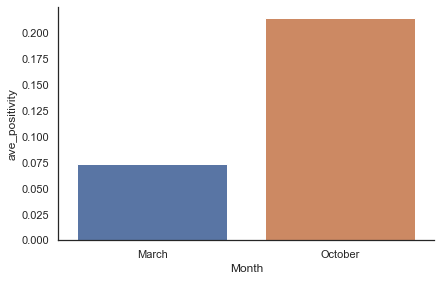

In [19]:
sns.set_theme(style="white")
ax = sns.barplot(x='Month', y="ave_positivity", data=df_positive)
sns.despine()

In [20]:
# Printing positive tweets 
print('Printing positive tweets:\n')
j=1
sortedDF = df_tweets.sort_values(by=['Polarity']) #Sort the tweets
for i in range(0, sortedDF.shape[0] ):
    if( sortedDF['Analysis'][i] == 'Positive'):
        print(str(j) + ') '+ sortedDF['tweet'][i])
        print()
        j= j+1

Printing positive tweets:

1) welcome new world



KeyError: 6

Prints the positive tweets in ascending order. The most positive tweet is the #1 tweet.

Prints the negative tweets in ascending order. The most negative tweet is the #1 tweet.

In [21]:
# Printing negative tweets  
print('Printing negative tweets:\n')
j=1
sortedDF = df_tweets.sort_values(by=['Polarity'],ascending=False) #Sort the tweets
for i in range(0, sortedDF.shape[0] ):
    if( sortedDF['Analysis'][i] == 'Negative'):
        print(str(j) + ') '+sortedDF['tweet'][i])
        print()
        j=j+1

Printing negative tweets:

1) use vpn exchanges kyc coinjoin loses data congrats ledger ill sats airgap wallet like bought looking forward test protect



KeyError: 6

Print the percentage of positive tweets. About 47.9% of the tweets are considered positive tweets.

In [22]:
# Print the percentage of positive tweets
ptweets = df_tweets[df_tweets.Analysis == 'Positive']
ptweets = ptweets['tweet']
ptweets
round( (ptweets.shape[0] / df_tweets.shape[0]) * 100 , 1)

47.9

Print the percentage of negative tweets. About 6.0% of the tweets are considered negative tweets.

In [23]:
# Print the percentage of negative tweets
ntweets = df_tweets[df_tweets.Analysis == 'Negative']
ntweets = ntweets['tweet']
ntweets

round( (ntweets.shape[0] / df_tweets.shape[0]) * 100, 1)

6.0

In [24]:
# Show the value counts
df_tweets['Analysis'].value_counts()

Positive    6355
Neutral     6108
Negative     793
Name: Analysis, dtype: int64

Below we can observe the graphical representation of all the neutral, positive, and negative tweets for November 2020.

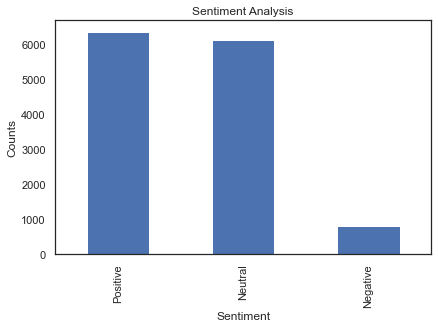

In [25]:
# Plotting and visualizing the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df_tweets['Analysis'].value_counts().plot(kind = 'bar')
plt.show()

## 4.0 Word Clouds

Let's observe how well the sentiments are distributed by plotting the common words in a word clouds.
- Word cloud (also known as text clouds or tag clouds) is a visualization, the more a specific word appears in the text, the bigger and bolder it appears in the word cloud.

It looks like the words "participate" and "amazing" appear a lot for Bitcoins past 14,000+ tweets.

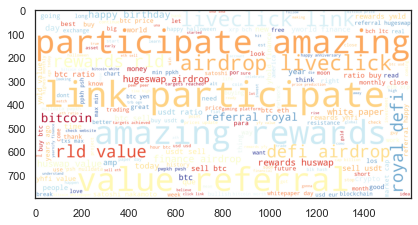

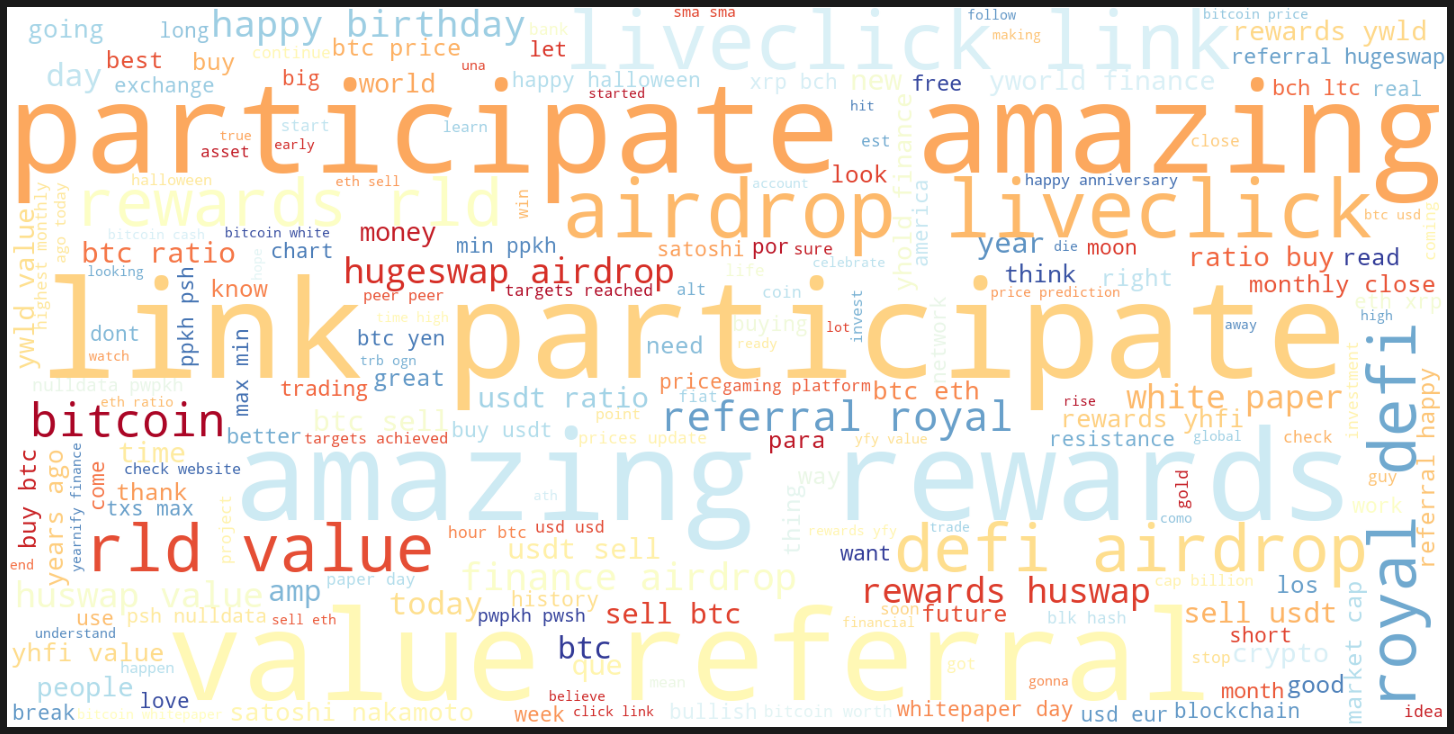

In [33]:
# Generate the Bitcoin word cloud
allWords = ' '.join([twts for twts in df_tweets['tweet']])
wordcloud = WordCloud(background_color='white', colormap="RdYlBu", width=1600, height=800).generate(allWords)
plt.imshow(wordcloud)

plt.figure( figsize=(20,10), facecolor='k')
# fontdict = {"fontsize": 50, "fontweight": "bold"}
# plt.title("Bitcoin Word Cloud", fontdict=fontdict)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## 5.0 Named Entity Recognition

In this section, a named entity recognition (NER) model was created and visualized the tags using SpaCy.

In [29]:
# Concatenate all of the bitcoin text together
flat_btc_text_str = " ".join(df_tweets.tweet.to_list())
print(flat_btc_text_str)

yworld finance airdrop liveclick link participate amazing rewards ywld value referral makes new ath btc usd btc usd royal defi airdrop liveclick link participate amazing rewards rld value referral  play cashback play higher rank cashback username user btc usd btc usd thank yworld finance airdrop liveclick link participate amazing rewards ywld value referral btc usd btc usd   million number divisible numbers cosmic power propagate new consciousness value let yfi holy kore hate uni farm inj xvs sxp fio easy bot kpr surf yeld core pria kper orai fmta tens stacy nice prq pols stake ocean bond happy birthday chart shows interesting phenomenon needs consecutive days price hold floor btc usd btc usd speed finance airdrop liveclick link participate amazing rewards spfi value referral    royal defi airdrop liveclick link participate amazing rewards rld value referral  espiral muerte min rejection coming getting freaky bcqpwngcxrkepjjmjyekfvchztqkepamhu btc hold hereif mother face rippers monday

In [30]:
# Run the NER processor on all of the text
btc_doc = nlp(flat_btc_text_str)
btc_doc.user_data["title"] = "Bitcoin NER"
# Add a title to the document

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
# Render the visualization
displacy.render(btc_doc,style='ent')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


spaCy tokenizes text in an entirely nondestructive manner. The underlying text does not change. spaCy does not explicitly break the original text into a list, but tokens can be accessed by index span.

spaCy provides syntactic parsing to show word usage, thus creating a dependency tree

In [32]:
# List all Entities
for ent in btc_doc.ents:
    print(ent.text, ent.label_, ent.lemma_, ent.text)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
yworld finance airdrop liveclick ORG yworld finance airdrop liveclick yworld finance airdrop liveclick
btc usd btc PERSON btc usd btc btc usd btc
yfi PERSON yfi yfi
xvs sxp PERSON xvs sxp xvs sxp
yeld core ORG yeld core yeld core
pria kper GPE pria kper pria kper
ocean bond PERSON ocean bond ocean bond
birthday chart PERSON birthday chart birthday chart
consecutive days DATE consecutive day consecutive days
monday DATE monday monday
portfolio past hours TIME portfolio past hour portfolio past hours
btc usd btc usd  register PERSON btc usd btc usd   register btc usd btc usd  register
tronmax tronmin ORG tronmax tronmin tronm

In [209]:
spacy.explain("amod")

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'adjectival modifier'

In [210]:
for token in btc_doc:
    if token.dep_ == 'amod':
        print(f"ADJ MODIFIER: {token.text} --> NOUN: {token.head}")

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
ADJ MODIFIER: amazing --> NOUN: rewards
ADJ MODIFIER: new --> NOUN: btc
ADJ MODIFIER: amazing --> NOUN: referral
ADJ MODIFIER: higher --> NOUN: btc
ADJ MODIFIER: username --> NOUN: btc
ADJ MODIFIER: amazing --> NOUN: btc
ADJ MODIFIER: divisible --> NOUN: numbers
ADJ MODIFIER: cosmic --> NOUN: power
ADJ MODIFIER: new --> NOUN: value
ADJ MODIFIER: easy --> NOUN: bot
ADJ MODIFIER: nice --> NOUN: bond
ADJ MODIFIER: happy --> NOUN: chart
ADJ MODIFIER: interesting --> NOUN: phenomenon
ADJ MODIFIER: consecutive --> NOUN: days
ADJ MODIFIER: amazing --> NOUN: link
ADJ MODIFIER: amazing --> NOUN: rejection
ADJ MODIFIER: optimal --> N

### 5.1 Named Entity Recognition
To see which tokens spaCy identifies as named entities, I cycled through `btc_doc.ents`"

In [211]:
spacy.explain("GPE")

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Countries, cities, states'

In [212]:
for ent in btc_doc.ents:
    print(ent.text, ent.label_)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
yworld finance airdrop liveclick ORG
btc usd btc PERSON
yfi PERSON
xvs sxp PERSON
yeld core ORG
pria kper GPE
ocean bond PERSON
birthday chart PERSON
consecutive days DATE
monday DATE
portfolio past hours TIME
btc usd btc usd  register PERSON
tronmax tronmin ORG
coin airdrop liveclick ORG
year DATE
minutes TIME
years DATE
today years DATE
monthly DATE
para los que PERSON
que quienes compramos hace ORG
nulldata pwpkh pwsh PERSON
yfi PERSON
xvs sxp PERSON
yeld core ORG
pria kper GPE
dmgs PERSON
october DATE
xrp usd hoe beleggen PERSON
tronmax tronmin ORG
minutes TIME
monthly DATE
week ago DATE
txs max PERSON
pwsh usd multiple

## 6.0 Vectorizer
The Tweets were vectorized using Count and TFIDF Vectorizer below in preparation for topic modeling

In [31]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_tweets['tweet'], df_tweets['Analysis'], test_size=0.3, random_state=42)

### Count Vectorizer

In [35]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# The first document-term matrix has default Count Vectorizer values - counts of unigrams
# min_df sets parameter for columns with minimum amount of values
cv1 = CountVectorizer(stop_words='english', min_df=4)

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

X_train_cv1_df = pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names()).head()
X_train_cv1_df

#these words need to be removed!!!

abd  aber  ability  able  absolutely  acaba  accept  accepted  access  \
0    0     0        0     0           0      0       0         0       0   
1    0     0        0     0           0      0       0         0       0   
2    0     0        0     0           0      0       0         0       0   
3    0     0        0     0           0      0       0         0       0   
4    0     0        0     0           0      0       0         0       0   

   accessible  ...  zil  ziz  zize  zombie  zona  zone  zrx  zuckerberg  \
0           0  ...    0    0     0       0     0     0    0           0   
1           0  ...    0    0     0       0     0     0    0           0   
2           0  ...    0    0     0       0     0     0    0           0   
3           0  ...    0    0     0       0     0     0    0           0   
4           0  ...    0    0     0       0     0     0    0           0   

   zukunft  zum  
0        0    0  
1        0    0  
2        0    0  
3        0    0  
4        0    0  

[5 rows x 2518 columns]

In [36]:
# The second document-term matrix has both unigrams and bigrams, and indicators instead of counts
cv2 = CountVectorizer(ngram_range=(1,2), binary=True, stop_words='english', min_df=4)

X_train_cv2 = cv2.fit_transform(X_train)
X_test_cv2  = cv2.transform(X_test)

X_train_cv2_df = pd.DataFrame(X_train_cv2.toarray(), columns=cv2.get_feature_names()).head()
X_train_cv2_df

abd  aber  ability  able  absolutely  acaba  accept  accepted  access  \
0    0     0        0     0           0      0       0         0       0   
1    0     0        0     0           0      0       0         0       0   
2    0     0        0     0           0      0       0         0       0   
3    0     0        0     0           0      0       0         0       0   
4    0     0        0     0           0      0       0         0       0   

   accessible  ...  zize  zize defi  zombie  zombie videos  zona  zone  zrx  \
0           0  ...     0          0       0              0     0     0    0   
1           0  ...     0          0       0              0     0     0    0   
2           0  ...     0          0       0              0     0     0    0   
3           0  ...     0          0       0              0     0     0    0   
4           0  ...     0          0       0              0     0     0    0   

   zuckerberg  zukunft  zum  
0           0        0    0  
1           0        0    0  
2           0        0    0  
3           0        0    0  
4           0        0    0  

[5 rows x 3870 columns]

### TF-IDF

In [37]:
# Create TF-IDF versions of the Count Vectorizers created earlier in the exercise
# min_df parameter sets minimum amount/column
tfidf1 = TfidfVectorizer(stop_words='english',min_df=0.0004)
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_test_tfidf1  = tfidf1.transform(X_test)

pd.DataFrame(X_train_tfidf1.toarray(), columns=tfidf1.get_feature_names()).head()

abd  aber  ability  able  absolutely  acaba  accept  accepted  access  \
0  0.0   0.0      0.0   0.0         0.0    0.0     0.0       0.0     0.0   
1  0.0   0.0      0.0   0.0         0.0    0.0     0.0       0.0     0.0   
2  0.0   0.0      0.0   0.0         0.0    0.0     0.0       0.0     0.0   
3  0.0   0.0      0.0   0.0         0.0    0.0     0.0       0.0     0.0   
4  0.0   0.0      0.0   0.0         0.0    0.0     0.0       0.0     0.0   

   accessible  ...  zil  ziz  zize  zombie  zona  zone  zrx  zuckerberg  \
0         0.0  ...  0.0  0.0   0.0     0.0   0.0   0.0  0.0         0.0   
1         0.0  ...  0.0  0.0   0.0     0.0   0.0   0.0  0.0         0.0   
2         0.0  ...  0.0  0.0   0.0     0.0   0.0   0.0  0.0         0.0   
3         0.0  ...  0.0  0.0   0.0     0.0   0.0   0.0  0.0         0.0   
4         0.0  ...  0.0  0.0   0.0     0.0   0.0   0.0  0.0         0.0   

   zukunft  zum  
0      0.0  0.0  
1      0.0  0.0  
2      0.0  0.0  
3      0.0  0.0  
4      0.0  0.0  

[5 rows x 2518 columns]

In [38]:
tfidf2 = TfidfVectorizer(ngram_range=(1,2), binary=True, stop_words='english', min_df=0.0004)
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2  = tfidf2.transform(X_test)

pd.DataFrame(X_train_tfidf2.toarray(), columns=tfidf2.get_feature_names()).head()

abd  aber  ability  able  absolutely  acaba  accept  accepted  access  \
0  0.0   0.0      0.0   0.0         0.0    0.0     0.0       0.0     0.0   
1  0.0   0.0      0.0   0.0         0.0    0.0     0.0       0.0     0.0   
2  0.0   0.0      0.0   0.0         0.0    0.0     0.0       0.0     0.0   
3  0.0   0.0      0.0   0.0         0.0    0.0     0.0       0.0     0.0   
4  0.0   0.0      0.0   0.0         0.0    0.0     0.0       0.0     0.0   

   accessible  ...  zize  zize defi  zombie  zombie videos  zona  zone  zrx  \
0         0.0  ...   0.0        0.0     0.0            0.0   0.0   0.0  0.0   
1         0.0  ...   0.0        0.0     0.0            0.0   0.0   0.0  0.0   
2         0.0  ...   0.0        0.0     0.0            0.0   0.0   0.0  0.0   
3         0.0  ...   0.0        0.0     0.0            0.0   0.0   0.0  0.0   
4         0.0  ...   0.0        0.0     0.0            0.0   0.0   0.0  0.0   

   zuckerberg  zukunft  zum  
0         0.0      0.0  0.0  
1         0.0      0.0  0.0  
2         0.0      0.0  0.0  
3         0.0      0.0  0.0  
4         0.0      0.0  0.0  

[5 rows x 3870 columns]

## 7.0 Topic Modeling with Matrix Factorization

### 7.1 Latent Semantic Analysis (LSA)

Sklearn's TruncatedSVD is designed to perform singular value decomposition on a count vectorizer or TF-IDF vectorizer object. The [documentation](https://scikit-learn.org/stable/modules/decomposition.html) also discusses NMF and LDA.

> TruncatedSVD is very similar to PCA, but differs in that the matrix *X* does not need to be centered. When the columnwise (per-feature) means of *X* are subtracted from the feature values, truncated SVD on the resulting matrix is equivalent to PCA. In practical terms, this means that the TruncatedSVD transformer accepts scipy.sparse matrices without the need to densify them, as densifying may fill up memory even for medium-sized document collections.

> While the TruncatedSVD transformer works with any feature matrix, using it on tf–idf matrices is recommended over raw frequency counts in an LSA/document processing setting. In particular, sublinear scaling and inverse document frequency should be turned on (sublinear_tf=True, use_idf=True) to bring the feature values closer to a Gaussian distribution, compensating for LSA’s erroneous assumptions about textual data.

In [43]:
# Latent Semantic Analysis (LSA) is just another name for Singular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
lsa = TruncatedSVD(4)
btc_doc_topic = lsa.fit_transform(X_train_cv1)
lsa.explained_variance_ratio_

array([0.19093335, 0.0429373 , 0.02465786, 0.020575  ])

The U matrix shows us the 2 resulting topics, and the terms that are associated with each topic. In this case:

In [45]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2","component_3","component_4"],
             columns = cv1.get_feature_names())
topic_word

abd  aber  ability   able  absolutely  acaba  accept  accepted  \
component_1  0.000   0.0    0.000  0.000       0.000    0.0   0.000       0.0   
component_2  0.000   0.0    0.000  0.000       0.001    0.0   0.000       0.0   
component_3 -0.001  -0.0   -0.001 -0.001      -0.001   -0.0  -0.001      -0.0   
component_4  0.000  -0.0   -0.000 -0.000      -0.000   -0.0  -0.000      -0.0   

             access  accessible  ...    zil    ziz   zize  zombie  zona  \
component_1   0.000         0.0  ...  0.000  0.003  0.003   0.000   0.0   
component_2   0.001         0.0  ...  0.001 -0.000 -0.000   0.000   0.0   
component_3  -0.001        -0.0  ... -0.002 -0.000 -0.000  -0.001  -0.0   
component_4  -0.000        -0.0  ... -0.001 -0.005 -0.005   0.000   0.0   

              zone    zrx  zuckerberg  zukunft    zum  
component_1  0.000  0.000         0.0      0.0  0.000  
component_2  0.001  0.002         0.0      0.0  0.000  
component_3 -0.001 -0.002         0.0      0.0 -0.001  
component_4  0.000 -0.001        -0.0     -0.0 -0.000  

[4 rows x 2518 columns]

Below the function enables us to see the top words shown for each topic. 

In [46]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [47]:
display_topics(lsa, cv1.get_feature_names(), 5)


Topic  0
link, referral, airdrop, value, amazing

Topic  1
btc, sell, ratio, usdt, buy

Topic  2
usdt, sell, ratio, buy, try

Topic  3
defi, rld, royal, btc, yen


The Vt matrix shows us the documents we started with, and how each document is made up of the 4 resulting topics. In this case:
- Topic 0 seems to be about Fake Giveaways
- Topic 1 Selling Bitcoin
- Topic 2 Selling USDT
- Topic 3: DeFi

In [48]:
Vt = pd.DataFrame(btc_doc_topic.round(5),
             index = X_train,
             columns = ["component_1","component_2",'component_3','component_4' ])
Vt['component_1'].sort_values()

tweet
hbd                                                                                              0.00000
coolwallets                                                                                      0.00000
 cusdion creer vladimir feliz sbado bohemian rhapsody bottas                                     0.00000
waardestijging laatste uur gratis verdienen                                                      0.00000
vers sapprte faire une rserve internationale                                                     0.00000
                                                                                                  ...   
royal defi airdrop liveclick link participate amazing rewards rld value referral nice            3.26462
nice royal defi airdrop liveclick link participate amazing rewards rld value referral            3.26462
nice royal defi airdrop liveclick link participate amazing rewards rld value referral            3.26462
nice project royal defi airdrop liveclick link pa

Next we observe the cosine similarity.

In [49]:
cosine_similarity(Vt)

array([[ 1.        ,  0.42371616,  0.00134552, ...,  0.00134552,
        -0.00614297,  0.33723357],
       [ 0.42371616,  1.        , -0.01600465, ..., -0.01600465,
         0.04190111,  0.993081  ],
       [ 0.00134552, -0.01600465,  1.        , ...,  1.        ,
         0.80935161, -0.02718049],
       ...,
       [ 0.00134552, -0.01600465,  1.        , ...,  1.        ,
         0.80935161, -0.02718049],
       [-0.00614297,  0.04190111,  0.80935161, ...,  0.80935161,
         1.        ,  0.07755306],
       [ 0.33723357,  0.993081  , -0.02718049, ..., -0.02718049,
         0.07755306,  1.        ]])

In [50]:
cos_dtm = cosine_similarity(X_train_cv1_df).round(2)
cos_dtm

array([[1.  , 0.  , 0.  , 0.22, 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.22, 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  ]])

### 7.2 Non-Negative Matrix Factorization (NMF)

In this example, we are going to start with 4 documents that contain many unique words (or features). We will be using NMF this time around.

In [51]:
nmf_model = NMF(4)
btc_nmf_doc_topic = nmf_model.fit_transform(X_train_cv1)

The W matrix shows us the 4 resulting topics, and the terms that are associated with each topic.

In [52]:
topic_word_nmf = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2",'component_3','component_4'],
             columns = cv1.get_feature_names())
topic_word_nmf

abd   aber  ability   able  absolutely  acaba  accept  \
component_1  0.000  0.000    0.000  0.000       0.000    0.0   0.000   
component_2  0.005  0.001    0.004  0.003       0.007    0.0   0.002   
component_3  0.000  0.000    0.000  0.000       0.000    0.0   0.000   
component_4  0.000  0.000    0.001  0.001       0.000    0.0   0.001   

             accepted  access  accessible  ...    zil    ziz   zize  zombie  \
component_1       0.0   0.000       0.000  ...  0.000  0.024  0.024   0.000   
component_2       0.0   0.008       0.003  ...  0.011  0.000  0.000   0.003   
component_3       0.0   0.000       0.000  ...  0.000  0.000  0.000   0.000   
component_4       0.0   0.000       0.000  ...  0.001  0.028  0.028   0.000   

              zona   zone    zrx  zuckerberg  zukunft    zum  
component_1  0.000  0.000  0.000       0.000    0.000  0.000  
component_2  0.003  0.008  0.022       0.000    0.000  0.003  
component_3  0.000  0.000  0.000       0.001    0.002  0.000  
component_4  0.000  0.000  0.003       0.000    0.000  0.000  

[4 rows x 2518 columns]

In [53]:
display_topics(nmf_model, cv1.get_feature_names(), 10)


Topic  0
defi, value, referral, airdrop, link, rewards, amazing, participate, liveclick, rld

Topic  1
btc, sell, bitcoin, ratio, price, usd, buy, eth, yen, profit

Topic  2
usdt, sell, ratio, buy, eth, try, bnb, busd, wait, till

Topic  3
link, referral, airdrop, amazing, participate, value, rewards, liveclick, finance, huswap


The H matrix shows us the documents we started with, and how each document is made up of the 4 resulting topics. In this case:
- Topic 0: Giveaways
- Topic 1 Selling Bitcoin
- Topic 2 Selling USDT
- Topic 3: Giveaways

In [54]:
H = pd.DataFrame(btc_nmf_doc_topic.round(5),
             index = X_train,
             columns = ["component_1","component_2",'component_3','component_4' ])
H

component_1  component_2  \
tweet                                                                          
hbarbuy btc sell btc ratio buy btc sell btc ratio       0.00000      0.53220   
todo mundo hablando del confinamiento halloween...      0.00000      0.00523   
royal defi airdrop liveclick link participate a...      0.30496      0.00000   
horse owner called car scam today horse horse c...      0.00000      0.12649   
bitcoin peer peer electronic cash title introdu...      0.00000      0.05277   
...                                                         ...          ...   
blk hash eadfdbcdaecdfceffccbcfdaae txs max min...      0.00000      0.00370   
mind                                                    0.00000      0.00008   
royal defi airdrop liveclick link participate a...      0.30496      0.00000   
hugeswap airdrop liveclick link participate ama...      0.00000      0.00000   
happy whitepaper day                                    0.00000      0.01120   

                                                    component_3  component_4  
tweet                                                                         
hbarbuy btc sell btc ratio buy btc sell btc ratio       0.27407      0.00000  
todo mundo hablando del confinamiento halloween...      0.00000      0.00000  
royal defi airdrop liveclick link participate a...      0.00000      0.00000  
horse owner called car scam today horse horse c...      0.00000      0.00000  
bitcoin peer peer electronic cash title introdu...      0.00000      0.00034  
...                                                         ...          ...  
blk hash eadfdbcdaecdfceffccbcfdaae txs max min...      0.00000      0.00000  
mind                                                    0.00000      0.00003  
royal defi airdrop liveclick link participate a...      0.00000      0.00000  
hugeswap airdrop liveclick link participate ama...      0.00000      0.51958  
happy whitepaper day                                    0.00000      0.00034  

[9279 rows x 4 columns]

In [172]:
# need to fix
# Set categories
categories = ['bitcoin', 'paypal', 'crypto']

# Download the training subset of the 20 NG dataset, with headers, footers, quotes removed
# Only keep docs from the 6 categories above
ng_train = X_train_cv1_df(subset='train', categories=categories, 
                                      remove=('headers', 'footers', 'quotes'))

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 8.0 Topic Modeling with sklearn and pyLDAvis

Adapted from [the official pyLDAvis repo demo](https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb).

We'll try out [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) on the [20 Newsgroups dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html) with some simple preprocessing.

In [34]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(X_train)
print(dtm_tf.shape)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
(10479, 1061)


In [35]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(X_train)
print(dtm_tfidf.shape)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
(10479, 1061)


### 8.1 Fit the Latent Dirichlet Allocation models

In [36]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tf.fit(dtm_tf)

# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tfidf.fit(dtm_tfidf)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(n_components=20, random_state=0)

## 8.2 pyLDAvis

Recall the 4 categories we extracted:

* Topic 0: Giveaways
* Topic 1 Selling Bitcoin
* Topic 2 Selling USDT
* Topic 3: Giveaways

Let's use [pyLDAvis](http://bl.ocks.org/AlessandraSozzi/raw/ce1ace56e4aed6f2d614ae2243aab5a5/) to see our topics, and to see if they match up with our expectations.

* The left panel visualizes the topics as circles in the two-dimensional plane whose centres are determined by computing the Jensen–Shannon divergence between topics, and then by using [multidimensional scaling](https://en.wikipedia.org/wiki/Multidimensional_scaling) to project the inter-topic distances onto two dimensions. Each topic’s overall prevalence is encoded using the areas of the circles.

* The right panel depicts a horizontal bar chart whose bars represent the individual terms that are the most useful for interpreting the currently selected topic on the left. A pair of overlaid bars represent both the corpus-wide frequency of a given term as well as the topic-specific frequency of the term.

* The λ slider allows to rank the terms according to term relevance. By default, the terms of a topic are ranked in decreasing order according their topic-specific probability ( λ = 1 ). Moving the slider allows to adjust the rank of terms based on much discriminatory (or "relevant") are for the specific topic. The suggested “optimal” value of λ is 0.6. [Small values of λ (near 0) highlight potentially rare, but exclusive terms for the selected topic, and large values of λ (near 1) highlight frequent, but not necessarily exclusive, terms for the selected topic.](http://www.kennyshirley.com/LDAvis/)

In [37]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.460423  0.079846       1        1  21.563546
16    -0.455740  0.075193       2        1  12.048164
9      0.129297  0.081711       3        1   7.006192
8      0.068520 -0.067385       4        1   6.203631
7      0.088346 -0.096557       5        1   5.301324
19     0.120487  0.201993       6        1   4.756877
15     0.094929  0.283855       7        1   4.148491
11     0.063195 -0.169362       8        1   4.017856
2     -0.102392 -0.144626       9        1   3.958676
13     0.036659 -0.071551      10        1   3.798927
18     0.079531  0.113222      11        1   3.770347
4      0.038855 -0.154764      12        1   3.533829
17     0.087940  0.142223      13        1   3.078113
12     0.063744  0.108921      14        1   3.019678
6     -0.022177 -0.138081      15        1   2.695062
0      0.072130  0.012138      16        1   2.501030
1      0.036501 -0.038680      17        1   2.380398
10     0.006052 -0.047371      18        1   2.318713
5      0.018043 -0.129950      19        1   2.000307
3      0.036504 -0.040775      20        1   1.898837, topic_info=             Term         Freq        Total Category  logprob  loglift
122           btc  1442.000000  1442.000000  Default  30.0000  30.0000
31        amazing  1909.000000  1909.000000  Default  29.0000  29.0000
649   participate  1889.000000  1889.000000  Default  28.0000  28.0000
764       rewards  1883.000000  1883.000000  Default  27.0000  27.0000
524     liveclick  1863.000000  1863.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1037         year    30.235069   123.078264  Topic20  -3.6400   2.5601
397      hashrate    16.105593    27.351904  Topic20  -4.2699   3.4343
871        supply    16.865223    37.308693  Topic20  -4.2238   3.1700
734       reached    16.140806    72.678957  Topic20  -4.2677   2.4592
697         price    17.517368   461.033902  Topic20  -4.1859   0.6937

[910 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4         3  0.240030  according
4        17  0.720089  according
7         9  0.986796   achieved
8         9  0.071282        act
8        15  0.142564        act
...     ...       ...        ...
1057      9  0.893612        zil
1057     15  0.083127        zil
1058     20  0.964940        ziz
1059     20  0.964940       zize
1060     11  0.950149     zombie

[1363 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 17, 10, 9, 8, 20, 16, 12, 3, 14, 19, 5, 18, 13, 7, 1, 2, 11, 6, 4])

The topics for our TFIDFVectorizer LDA also appear to match up with our newsgroups categories, though not as cleanly:

#### Change below!!!
* Topic 1: Giveaway - defi, value, link, amazing
* Topic 2: Giveaway - link, value, amazing, airdrop 
* Topic 3: Buy - time, buy, today, bitcoin, years
* Topic 4: Sell - btc, sell, ratio, usdt

Let's revisit the CountVectorizer LDA model. We can adjust multidimensional scaling to get "cleaner" topic bubbles.

In [151]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='mmds')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.498389  0.141077       1        1  21.558320
16     0.470507  0.197535       2        1  12.041961
9     -0.069279 -0.202906       3        1   6.971763
8     -0.449637 -0.121262       4        1   6.180647
7      0.115094 -0.208094       5        1   5.286721
19    -0.273707 -0.254518       6        1   4.584403
15    -0.272293 -0.381889       7        1   4.396883
11    -0.081426  0.110197       8        1   4.057141
2      0.128133  0.449420       9        1   3.964287
13     0.365507 -0.289863      10        1   3.830210
18     0.159432 -0.409250      11        1   3.822411
4     -0.059682  0.435030      12        1   3.559667
17     0.142345  0.055864      13        1   3.092618
12    -0.309442  0.318150      14        1   3.019601
6      0.220192  0.305900      15        1   2.667129
0     -0.166463  0.260906      16        1   2.502860
1     -0.319471  0.004914      17        1   2.375513
10    -0.453798  0.182118      18        1   2.223584
5      0.377789 -0.125703      19        1   2.041578
3     -0.022190 -0.467626      20        1   1.822704, topic_info=            Term         Freq        Total Category  logprob  loglift
122          btc  1443.000000  1443.000000  Default  30.0000  30.0000
31       amazing  1910.000000  1910.000000  Default  29.0000  29.0000
649  participate  1890.000000  1890.000000  Default  28.0000  28.0000
764      rewards  1883.000000  1883.000000  Default  27.0000  27.0000
524    liveclick  1863.000000  1863.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
430         hour    28.986339   113.380373  Topic20  -3.6415   2.6409
871       supply    18.228102    37.475336  Topic20  -4.1054   3.2841
397     hashrate    16.053232    27.278075  Topic20  -4.2325   3.4747
734      reached    14.856047    72.393733  Topic20  -4.3100   2.4211
697        price    16.032090   460.075885  Topic20  -4.2338   0.6481

[910 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4         3  0.239616  according
4        17  0.718848  according
7         9  0.962682   achieved
8         9  0.071059        act
8        17  0.852713        act
...     ...       ...        ...
1057      9  0.894383        zil
1057     15  0.083198        zil
1058     20  0.967964        ziz
1059     20  0.967964       zize
1060     11  0.954573     zombie

[1360 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 17, 10, 9, 8, 20, 16, 12, 3, 14, 19, 5, 18, 13, 7, 1, 2, 11, 6, 4])

In [152]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='tsne')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
14     -10.878068   10.538728       1        1  21.558320
16     -60.884026  -75.591820       2        1  12.041961
9       -2.336119  -53.289074       3        1   6.971763
8      -61.385319  -12.914634       4        1   6.180647
7      -28.737743  126.296997       5        1   5.286721
19       1.066606 -123.552811       6        1   4.584403
15      45.140720   -7.947869       7        1   4.396883
11    -140.795975  -98.530548       8        1   4.057141
2       61.531681  -83.240562       9        1   3.964287
13     -72.563057 -140.396881      10        1   3.830210
18      15.984491   63.578186      11        1   3.822411
4     -160.851624   68.945145      12        1   3.559667
17      85.961830   51.922935      13        1   3.092618
12     -99.020836  109.936348      14        1   3.019601
6     -176.764130   -8.681684      15        1   2.667129
0     -117.189880  -37.420200      16        1   2.502860
1      108.829918  -22.946203      17        1   2.375513
10      47.588097  121.934814      18        1   2.223584
5     -106.467834   30.176889      19        1   2.041578
3      -50.613804   59.328842      20        1   1.822704, topic_info=            Term         Freq        Total Category  logprob  loglift
122          btc  1443.000000  1443.000000  Default  30.0000  30.0000
31       amazing  1910.000000  1910.000000  Default  29.0000  29.0000
649  participate  1890.000000  1890.000000  Default  28.0000  28.0000
764      rewards  1883.000000  1883.000000  Default  27.0000  27.0000
524    liveclick  1863.000000  1863.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
430         hour    28.986339   113.380373  Topic20  -3.6415   2.6409
871       supply    18.228102    37.475336  Topic20  -4.1054   3.2841
397     hashrate    16.053232    27.278075  Topic20  -4.2325   3.4747
734      reached    14.856047    72.393733  Topic20  -4.3100   2.4211
697        price    16.032090   460.075885  Topic20  -4.2338   0.6481

[910 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4         3  0.239616  according
4        17  0.718848  according
7         9  0.962682   achieved
8         9  0.071059        act
8        17  0.852713        act
...     ...       ...        ...
1057      9  0.894383        zil
1057     15  0.083198        zil
1058     20  0.967964        ziz
1059     20  0.967964       zize
1060     11  0.954573     zombie

[1360 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 17, 10, 9, 8, 20, 16, 12, 3, 14, 19, 5, 18, 13, 7, 1, 2, 11, 6, 4])

## 8.3 CorEx Topic Modeling
__As a comparison, LDA is a generative model, which starts from Y (documents/words) to determine X (topic models)__
  * Assumes that in the backend, X (topic models) ultimately generates Y (documents)
      * Question to answer is "How was Y generated?"
  * You need to actually find what X is

* Uses fancy math to find X, and you get two matrices:
  * Probability of word given a topic
  * Probability of topic given a document

__CorEx is a discriminative model, which starts from X (documents/words) to determine Y (topics models)__
  * This should make sense, as it's more or less how humans try to do determine topics when reading lots of documents 
      * Question to answer is "How do we group X?"
  * Basically, this means that LDA and CorEx are different, so one might work better than another in some contexts

__CorEx looks for groups of words that are in the same topic AKA have high Total Correlation (TC) AKA convey the same *information*__
  * Information can be defined as entropy
    * Think of entropy as how many documents a word might appear (this is NOT THE RIGHT definition, but will help you get an intuitive understanding)

* Specifically, TC(group of words) = SUM(ENTROPY(Each Individual Word) - ENTROPY(group of words)

__If words are TIGHTLY RELATED (always appear together in the same topic/document), TC will be high. This is a good topic.__
  * TC(group of words) = SUM(ENTROPY(Each Individual Word) - ENTROPY(group of words)

__If entropy('basket') = 8, entropy('ball') = 8, entropy('player') = 8 and *they overlap exactly*, entropy(group) = 8__

* entropy('basket') + entropy('ball') + entropy('player') - entropy(group) = 8 + 8 + 8 - 8 = 16

__If the words are all INDEPENDENT (never appear together in the same document or topic), TC = 0. This is a bad topic.__
  * TC(group of words) = SUM(ENTROPY(Each Individual Word) - ENTROPY(group of words)

__If entropy('politics') = 8 and entropy('family') = 8, and there is no overlap, entropy(group) = 16__

 * entropy('politics') + entropy('family') - entropy(group) = 8 + 8 - 16 = 0

__CorEx looks for a group of words that are both as broad (in many documents) and overlapping as possible (both together will lead to high TC)__
  * This is a topic

__Then, you look for another set of words (not overlapping with your previous group) with as high a TC as possible__
  * This is your next topic

  * __As you create more topics, each subsequent topic will have lower TC__
    * As there are fewer words left, "pool of entropy" to choose from is smaller
    * Harder to find many related many words that are overlapping as the low hanging fruit has already been put into topics

#### 8.3.1 Pre-process the Data
Note that the default for CorEx is to use CountVectorizer with __binary=True__.

It has not been tested, so the makers of CorEx cannot vouch for it, but if there are large documents, it may be worth trying splitting into shorter documents, TF-IDF, binary=False, average binary bag of words, etc.

In [1]:
vectorizer = CountVectorizer(max_features=20000,
                             stop_words='english', token_pattern="\\b[a-z][a-z]+\\b",
                             binary=True)

doc_word = vectorizer.fit_transform(X_train)
words = list(np.asarray(vectorizer.get_feature_names()))

In [119]:
# words is your list of words used in your corpus
# I recommend adding docs=df.data to make it easier to check which sentences are in each resulting topic
topic_model = ct.Corex(n_hidden=4, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=X_train)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 8.3.2 Interpretation of topics and tweets associated with topics

In [160]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
0: participate,airdrop,amazing,liveclick,referral,rewards,value,link,rld,royal
1: ltc,eth,bch,que,xrp,del,los,targets,aos,usd
2: money,today,people,like,amp,time,world,going,think,new
3: bot,recommended,sites,max,pwsh,psh,blk,nulldata,ppkh,pwpkh
4: paper,white,cash,peer,electronic,day,anniversary,published,book,address
5: years,price,ago,satoshi,nakamoto,market,prediction,cap,whitepaper,billion


Top tweets associated with a topic

In [121]:
# Let's check out topic : graphics
topic_model.get_top_docs(topic=2, n_docs=2)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('tis called cleptocracy git', 0.0),
 ('una gran bendicin bond arsenal gualeguay antonella bond spotify', 0.0)]

Use the .labels attribute to find the topic labels associated with each document that you trained on.

Use the .predict() method to predict labels based on a __new doc_word__

In [163]:
# Note, instead of using .predict(doc_word), you can also call topic_model.labels
predictions = pd.DataFrame(topic_model.predict(doc_word), columns=['topic'+str(i) for i in range(6)])
predictions.head(3)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic0  topic1  topic2  topic3  topic4  topic5
0   False   False    True    True   False    True
1   False   False   False    True   False   False
2   False   False   False    True   False   False

Note that some documents have 0 topics, and some documents have more than 1 topic
  * You can also use .p_y_given_x for for probabilities instead of True/False

### 8.3.3 Determining how many topics to have
The makers of CorEx have a created a cool plotting function to see what the TC of each topic is. 
  * Look for an elbow (either at 1 topic or 4 topics) and you can create a cut-off there

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


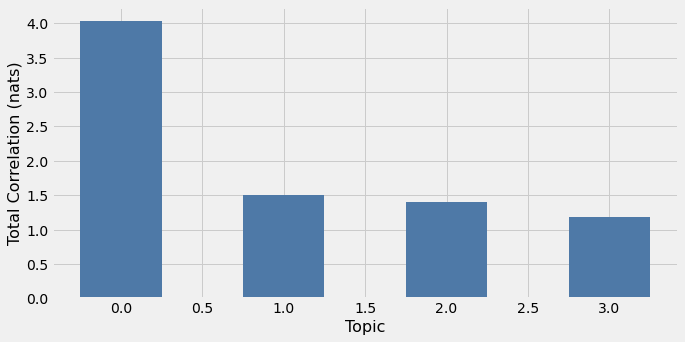

In [122]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

### 8.3.4 Other Ways to Use CorEx
  * Use your domain knowledge (use anchors)
  * Use low anchor strength (2) in order to have as broad a match as possible

In [165]:
topic_model = ct.Corex(n_hidden=6, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=X_train, 
                anchors=[['bitcoin'], 
                         ['ath'], 
                         ['moon'], 
                         ['btc'],
                         ['buy'], 
                         ['hodl']], anchor_strength=2)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
0: participate,referral,airdrop,liveclick,amazing,rewards,value,link,rld,royal
1: ath,que,del,targets,los,aos,por,para,precio,reached
2: moon,amp,free,fees,blue,trade,balances,blockfi,apy,borrow
3: btc,ratio,sell,eth,usdt,bch,price,ltc,usd,xrp
4: buy,years,ago,today,time,money,people,world,like,know
5: hodl,gaming,username,platform,dividends,bond,hunt,enter,channelaltcoins,zombie


  * __Highlight smaller topics that may be otherwise hidden by larger topics (use anchors)__
  * Use high anchor strength (5+) in order to force topics
    * Likely means that there will be fewer documents matched to the topic

In [2]:
topic_model = ct.Corex(n_hidden=6, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=X_train, 
#Why the double brackets??
                anchors=[['buy', 'bitcoin'], 'ethereum'], anchor_strength=10)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

  * __To see how the same word can be used in different topics (use anchors)__
  * Anchor the same word multiple times

In [167]:
topic_model = ct.Corex(n_hidden=8, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=X_train, 
                anchors=[['hodl'], ['hodl'], ['hodl'], ['hodl']], anchor_strength=5)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
0: hodl,del,que,los,aos,para,por,precio,hoy,feliz
1: hodl,follow,money,username,platform,gaming,currency,easy,let,digital
2: hodl,electronic,peer,est,pour,cash,vet,bir,req,borrow
3: hodl,targets,join,min,yen,reached,prediction,profit,zil,nulldata
4: like,time,market,high,close,monthly,today,new,going,people
5: happy,birthday,paper,white,whitepaper,years,satoshi,nakamoto,day,anniversary
6: sell,ratio,usdt,bch,ltc,eth,xrp,btc,eos,qnt
7: participate,airdrop,amazing,liveclick,rewards,referral,value,link,rld,royal


#### 8.3.5 Resources and other ways to use CorEx

  * Main page: https://github.com/gregversteeg/corex_topic
  * Example notebook (MUST READ!): https://github.com/gregversteeg/corex_topic/blob/master/corextopic/example/corex_topic_example.ipynb
  
Things to try:
  * Making documents shorter / longer
  * TF-IDF
  * Average binary bag of words
  * All your standard NLP (stop words, lemmatization, etc.)

## 9.0 Word2Vec and GloVe
Word2Vec is a very powerful and useful word embedding method. Gensim comes equipped with ways for us to train our own Word2Vec model, or load in a pre-trained word2vec model.

In [40]:
tokenized_docs = [gensim.utils.simple_preprocess(d) for d in df_tweets['tweet']] 

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
# size refers to the desired dimension of our word vectors
# window refers to the size of our context window
# why am I using skipgram?
# sg means that we are using the Skip-gram architecture

model1 = gensim.models.Word2Vec(tokenized_docs, size=5, window=2,min_count=1, sg=1)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
model1.most_similar('btc' ,topn=10)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-49-4ac386b9b21b>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model1.most_similar('btc' ,topn=10)


[('sell', 0.9970859885215759),
 ('etm', 0.9966350793838501),
 ('contemporary', 0.9963101148605347),
 ('comedian', 0.9962829351425171),
 ('ratio', 0.996185302734375),
 ('busd', 0.9954038858413696),
 ('lfgo', 0.9951395392417908),
 ('flows', 0.995015561580658),
 ('sats', 0.9948916435241699),
 ('try', 0.9948425889015198)]

Based on topics from above:
- participate,referral,airdrop,liveclick,amazing,rewards,value,link,rld,royal
- ath,que,del,targets,los,aos,por,para,precio,reached
- moon,amp,free,fees,blue,trade,balances,blockfi,apy,borrow
- btc,ratio,sell,eth,usdt,bch,price,ltc,usd,xrp
- buy,years,ago,today,time,money,people,world,like,know
- hodl,gaming,username,platform,dividends,bond,hunt,enter,channelaltcoins,zombie

In [48]:
model1.similarity('btc','hodl')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-48-b2ecf64678ef>:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  model1.similarity('btc','hodl')


0.8591994

In [51]:
# Positive Negative Similar Words
model1.most_similar(positive=['btc', 'buy'], negative=['sell'])

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-51-f3d82c8bde04>:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model1.most_similar(positive=['btc', 'buy'], negative=['sell'])


[('borsalarn', 0.9982602596282959),
 ('confidently', 0.9970005750656128),
 ('previsibilidad', 0.9967029094696045),
 ('systmes', 0.9964122772216797),
 ('cercenar', 0.9959374070167542),
 ('flows', 0.9957482218742371),
 ('result', 0.995587944984436),
 ('frontbuy', 0.9948864579200745),
 ('price', 0.9944294691085815),
 ('thriller', 0.9941592216491699)]

In [53]:
model1.most_similar(positive=['btc', 'buy'], topn=5)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-53-0849892c15ef>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model1.most_similar(positive=['btc', 'buy'], topn=5)


[('flows', 0.9987806081771851),
 ('etm', 0.998173713684082),
 ('contemporary', 0.9973026514053345),
 ('borsalarn', 0.9969292283058167),
 ('comedian', 0.9966676235198975)]

Training our own model with word2vec is pretty cool, but it requires us to have a large corpus of data.

Fortunately, research groups at Stanford and Google have made their pre-trained word embeddings publicly available for us to use!

Google's word2vec: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

GloVe: https://nlp.stanford.edu/projects/glove/

Just note that these model's will require ~4 GB of RAM to fit in memory

In [1]:
# We are using vectors of length 200. Lesser vectors lessen processing time.
glove_file = './../Data/word_embeddings/glove.twitter.27B/glove.twitter.27B.200d.txt'
tmp_file = get_tmpfile("glove_word2vec.txt")

# call glove2word2vec script
# default way (through CLI): python -m gensim.scripts.glove2word2vec --input <glove_file> --output <w2v_file>
glove2word2vec(glove_file, tmp_file)

model = KeyedVectors.load_word2vec_format(tmp_file)

In [2]:
type(model.vocab)

dict

In [3]:
# Number of Vectors
len(model.vocab.keys())

1193514

In [4]:
# Size of the Vectors
model.vector_size

200

### 9.1 Exploring Word2Vec Vectors
* Print out a few word vectors from the Google set
* Print out the similarity between the following pairs (feel free to experiment with more if you like):
  * baseball, bat
  * baseball, ocean
  * bat, fly
* What sorts of patterns do you notice?  Where does it succeed?  Where does it fail?  How might one improve it?
* Print out the most similar words to the following words:
  * baseball
  * president
* Print out words similar to the positive words and dissimilar to the negative words for the following positive/negative groups:
* Print out the words that don't match the others in each of the following groups:

In [6]:
# Word Vectors
model.word_vec('bitcoin')

array([-0.074393 ,  0.10186  , -0.049351 , -0.53166  ,  0.25706  ,
       -0.5222   ,  0.17046  , -0.18893  ,  0.28897  , -0.12184  ,
        0.12619  ,  0.10341  , -1.0856   , -0.34959  ,  0.069433 ,
       -0.093725 , -0.33688  ,  0.46042  ,  0.65069  , -0.48376  ,
       -0.30007  ,  0.1678   ,  0.57996  , -0.10948  , -0.66832  ,
        0.7577   ,  0.41654  , -0.052058 , -0.59622  , -0.087796 ,
        0.4622   , -0.013795 , -0.44185  , -0.40651  ,  0.92432  ,
       -0.43312  , -0.012119 , -0.16346  ,  0.011646 , -0.33362  ,
        0.1437   ,  0.15696  ,  0.039093 ,  0.079893 ,  0.84927  ,
       -0.6614   , -0.76457  , -0.33192  ,  0.18674  ,  0.79411  ,
        0.57455  ,  0.1395   , -0.52864  ,  0.38603  ,  0.16032  ,
        0.52374  ,  0.49671  ,  0.37611  , -0.40939  ,  0.11506  ,
       -0.31058  , -0.2225   ,  0.34445  ,  0.01097  ,  0.64503  ,
       -0.063416 ,  0.4637   ,  0.29511  , -0.48942  ,  0.78048  ,
        0.52689  , -0.36406  ,  0.04378  ,  0.26221  ,  0.1767

In [7]:
# Pairwise Similarity
# Word2Vec captures some interesting similarities between words, such as the relationship between **bitcoin --> crypto**
model.similarity('bitcoin', 'crypto')

0.44594115

* Word Sense Disambiguation

In [8]:
# Most similar words
model.similar_by_word('bitcoin')

[('bitcoins', 0.6961264610290527),
 ('gox', 0.613304853439331),
 ('currency', 0.5955000519752502),
 ('exchange', 0.586264431476593),
 ('btc', 0.5816957354545593),
 ('dogecoin', 0.5782854557037354),
 ('trading', 0.5429692268371582),
 ('paypal', 0.5402452349662781),
 ('mining', 0.5222750902175903),
 ('commodity', 0.520323634147644)]

In [10]:
# Positive Negative Similar Words
model.most_similar(positive=['bit', 'gox'], negative=['scheme'])

[('abit', 0.4347763657569885),
 ('alittle', 0.41617801785469055),
 ('mt.', 0.4082877039909363),
 ('slightly', 0.401253879070282),
 ('little', 0.3616727590560913),
 ('pain', 0.34664636850357056),
 ('calmed', 0.3462069034576416),
 ('sad', 0.34080612659454346),
 ('angry', 0.340280145406723),
 ('much', 0.336826354265213)]

In [11]:
# Positive Negative Similar Words
model.most_similar(positive=['bit', 'gox'], negative=['scheme'],)

[('abit', 0.4347763657569885),
 ('alittle', 0.41617801785469055),
 ('mt.', 0.4082877039909363),
 ('slightly', 0.401253879070282),
 ('little', 0.3616727590560913),
 ('pain', 0.34664636850357056),
 ('calmed', 0.3462069034576416),
 ('sad', 0.34080612659454346),
 ('angry', 0.340280145406723),
 ('much', 0.336826354265213)]

It can also detect words that don't belong in a sequence:

In [14]:
# Words that don't match
model.doesnt_match(['breakfast', 'dinner'])

'breakfast'

Word similarities

In [17]:
# Comparing via Cosine Similarity
model.n_similarity(['bitcoin', 'crypto'], ['blockchain', 'crypto'])

0.73180556

In [21]:
# Comparing via Word Mover's Distance

model.wmdistance(['bitcoin', 'crypto'], ['blockchain', 'crypto'])

3.9035424510822296

In [23]:
model.wmdistance("Bitcoin is the best of cryptocurrency".lower().split(), 
                        "Ethereum is the best of cryptocurrency".lower().split())

1.427231936853526

Other Resources:      
Doc2Vec extends the word2vec algorithm to larger blocks of texts (paragraphs, documents, articles):    
- https://radimrehurek.com/gensim/models/doc2vec.html
- http://learningaboutdata.blogspot.com/2014/06/plotting-word-embedding-using-tsne-with.html
- https://districtdatalabs.silvrback.com/modern-methods-for-sentiment-analysis
- https://radimrehurek.com/gensim/models/word2vec.html
- https://www.tensorflow.org/tutorials/word2vec

## 10.0 Takeaways
Utilizing sentiment analysis and topic modeling we were able to see what was most pertinent when it came to Bitcoin Tweets. We were able to observe the sentiment and see what topics were being discussed with, in this case, a higher positive sentiment. There were Tweets about giveaways, buying, and selling. Of course, there was also a topic for Bitcoin Whitepaper's Anniversary on October 31. Overall, this was a good way to observe what people Tweet in regards to Bitcoin, based on their sentiment. 